In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import numpy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def collate_fn(data):
    pics = []
    target = []
    for item in data:

        pics.append(numpy.array(item[0]))
        target.append(item[1])
    return {
        'data': torch.from_numpy(numpy.array(pics)).float() / 255,
        'target': torch.from_numpy(numpy.array(target)),
    }

In [5]:
trainset = datasets.MNIST('.', download=True, train=True)
testset = datasets.MNIST('.', download=True, train=False)

train_dataloader = DataLoader(trainset, batch_size=128, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=False, collate_fn=collate_fn)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Автоэнкодер

In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 4, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU())
        
        self.decoder = nn.Sequential(nn.Conv2d(4, 16, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 32, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.Conv2d(32, 1, kernel_size=5, padding=2),
                                     nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
model = AutoEncoder()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()
num_epoches = 5
data_loaders = {'train' : train_dataloader, 'test' : test_dataloader}

In [10]:
for epoch in range(num_epoches):
  for k, loader in data_loaders.items():
    for batch in tqdm(loader):
      X_batch = batch['data'].to(device).unsqueeze(1)
      if k == 'train':
        model.train()
        optim.zero_grad()
        pred = model(X_batch)
        loss = loss_func(pred, X_batch)
        loss.backward()
        optim.step()
      else:
        model.eval()
        with torch.no_grad():
          pred = model(X_batch)
          loss = loss_func(pred, X_batch)
    print(f'Эпоха {epoch+1}, {k}: loss = {loss.item()}')


100%|██████████| 469/469 [00:07<00:00, 64.76it/s]


Эпоха 1, train: loss = 0.009251688607037067


100%|██████████| 79/79 [00:00<00:00, 134.59it/s]


Эпоха 1, test: loss = 0.008252163417637348


100%|██████████| 469/469 [00:06<00:00, 67.82it/s]


Эпоха 2, train: loss = 0.006677926052361727


100%|██████████| 79/79 [00:00<00:00, 137.12it/s]


Эпоха 2, test: loss = 0.006882944144308567


100%|██████████| 469/469 [00:07<00:00, 66.13it/s]


Эпоха 3, train: loss = 0.006171921268105507


100%|██████████| 79/79 [00:00<00:00, 138.92it/s]


Эпоха 3, test: loss = 0.006247730925679207


100%|██████████| 469/469 [00:06<00:00, 68.21it/s]


Эпоха 4, train: loss = 0.0055951522663235664


100%|██████████| 79/79 [00:00<00:00, 139.98it/s]


Эпоха 4, test: loss = 0.005364666227251291


100%|██████████| 469/469 [00:08<00:00, 57.58it/s]


Эпоха 5, train: loss = 0.004844916984438896


100%|██████████| 79/79 [00:00<00:00, 140.32it/s]

Эпоха 5, test: loss = 0.004925347864627838


In [11]:
test = testset.data[784].unsqueeze(0).unsqueeze(0).float() / 255
predict = model(test.to(device))

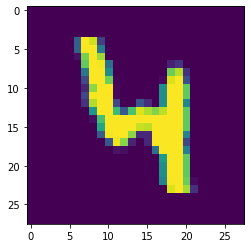

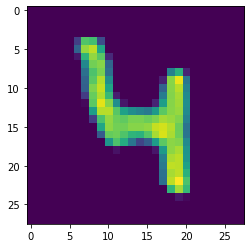

In [12]:
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()

## Вариационный автоэнкодер

In [16]:
def sampling(mu, sigma):
    return mu + sigma * torch.normal(torch.zeros_like(mu), torch.ones_like(mu))

In [17]:
def kl_loss(mu, sigma):
    p = torch.distributions.Normal(mu, sigma)
    q = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(sigma))
    return torch.distributions.kl_divergence(p,q).mean()

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()     

        self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                                     nn.MaxPool2d((2,2)),
                                     nn.ReLU(),
                                     nn.Conv2d(16, 16, kernel_size=3, padding=1),
                                     nn.MaxPool2d((2,2)),
                                     nn.Conv2d(16, 1, kernel_size=3, padding=1))
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(1, 16, kernel_size=5, padding=2),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(16, 1, kernel_size=3, padding=1),
                                     nn.ReLU())
        
    def forward(self, x):
        activation = nn.ReLU()
        mu, sigma = activation(self.encoder(x)), torch.exp(self.encoder(x))
        x = self.decoder(sampling(mu, sigma))
        return x, mu, sigma

In [19]:
model = VAE()
model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.MSELoss()

In [20]:
loaders = {"train": train_dataloader, "valid": test_dataloader}

In [21]:
for epoch in range(num_epoches):
  for k, loader in data_loaders.items():
    for batch in tqdm(loader):
      X_batch = batch['data'].to(device).unsqueeze(1)
      if k == 'train':
        model.train()
        optim.zero_grad()
        pred, mu, sigma = model(X_batch)
        loss = kl_loss(mu, sigma) + loss_func(pred, X_batch)
        loss.backward()
        optim.step()
      else:
        model.eval()
        with torch.no_grad():
          pred, mu, sigma = model(X_batch)
          loss = kl_loss(mu, sigma) + loss_func(pred, X_batch)
    print(f'Эпоха {epoch+1}, {k}: loss = {loss.item()}')

100%|██████████| 469/469 [00:07<00:00, 59.54it/s]


Эпоха 1, train: loss = 0.06922218948602676


100%|██████████| 79/79 [00:00<00:00, 88.81it/s]


Эпоха 1, test: loss = 0.07829973101615906


100%|██████████| 469/469 [00:07<00:00, 60.91it/s]


Эпоха 2, train: loss = 0.06980311125516891


100%|██████████| 79/79 [00:00<00:00, 91.34it/s]


Эпоха 2, test: loss = 0.07703820616006851


100%|██████████| 469/469 [00:07<00:00, 61.20it/s]


Эпоха 3, train: loss = 0.07020555436611176


100%|██████████| 79/79 [00:00<00:00, 88.68it/s]


Эпоха 3, test: loss = 0.07586353272199631


100%|██████████| 469/469 [00:07<00:00, 60.90it/s]


Эпоха 4, train: loss = 0.06681329756975174


100%|██████████| 79/79 [00:00<00:00, 87.66it/s]


Эпоха 4, test: loss = 0.07746504992246628


100%|██████████| 469/469 [00:07<00:00, 61.00it/s]


Эпоха 5, train: loss = 0.06776287406682968


100%|██████████| 79/79 [00:01<00:00, 59.15it/s]

Эпоха 5, test: loss = 0.07603110373020172


In [33]:
test = testset.data[784].unsqueeze(0).unsqueeze(0).float() / 255
predict, _, _ = model(test.to(device))

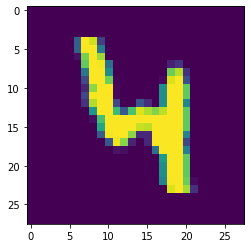

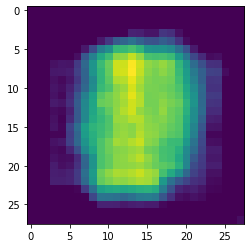

In [34]:
plt.imshow(test[0].view(28, 28).detach().numpy())
plt.show()

plt.imshow(predict[0][0].cpu().detach().numpy())
plt.show()